## Section D. Ridge Regression

### Question 6 [Ridge Regression, 25 Marks]

1. Given the gradient descent algorithms for linear regression (discussed in
Chapter 2 of Module 2), derive weight update steps of stochastic gradient
descent (SGD) as well as batch gradient descent (BGD) for linear
regression with L2 regularisation norm. Show your work with enough
explanation in your PDF report; you should provide the steps of SGD and
BGD, separately.
<br>

**Answer:** Answer is supplemented in the pdf report

2. Using R (with no use of special libraries), implement SGD and BGD algorithms that you derived in Step I.

In [39]:
# Load the libraries for wrangling and plotting data
library(reshape)
library(ggplot2)

In [40]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [41]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
   return(errors)
}

In the following SGD algorithm, the *sgd_update_weight()* function is updated and the gradient of regularization term (lambda*W_previous) is added.

In [42]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   grad = (- (y_true-y_pred) %*% x ) + lambda %*% W_prev
   return(W_prev - eta %*% grad)
}

Similar changes are done in the *bgd_update_weight()* function by adding the gradient of regularization term (lambda*W_previous).

In [43]:
##--- Batch Gradient Descent --------------------------------------------
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]

   W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
   W[1,] <- runif(ncol(train_x))

   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   trainin_size = dim(train_x)[1]
   for (tau in 1:max_epoch){
       
       #if (tau == tau_max) {break}
       
       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}

       # make prediction over the training set
       y_pred = train_x %*% W[tau,]

       # update the weight you may decide to chose linear search or not (we are not using line search here)
       W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)

       # keep track of the objective funtion
       obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
   } 
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   grad = (-colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x)) + lambda %*% W_prev
   return (W_prev - eta * grad)
}

3. Now let’s compare SGD and BGD implementations of ridge regression from Step 2:
<br> 

a. Load Task2A_train.csv and Task2A_test.csv sets.
<br>
b. Set the termination criterion as maximum of 20 weight updates for BGD, which is equivalent to 20 x N weight updates for SGD (where N is the number of training data).
<br>
c. Run your implementations of SGD and BGD while all parameter settings (initial values, learning rate etc) are exactly the same for both algorithms. During run, record training error rate every time the weights get updated. Create a plot of error rates (use different colors for SGD and BGD), where the x-axis is the number of visited data points and y-axis is the error rate. Save your plot in your Jupyter Notebook file for Question 6. Note that for every N errors for SGD in the plot, you will only have one error for BGD; the totallength of the x-axis will be 20 x N.

In [44]:
SGD <- function() {
   ## reading the data
   dtrain = read_data("Task2A_train.csv", TRUE)
   dtest = read_data("Task2A_test.csv", TRUE)
 
   ##### SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda=0
    
   # Get the weights using the training dataset
   train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
    
   # Calculate the errors
   errors = get_errors(dtrain, dtest, train_res$W) 
    
   # Return errors from the SGD function
   return(errors)

}

In [48]:
BGD <- function() {
   ## reading the data
   dtrain = read_data("Task2A_train.csv", TRUE)
   dtest = read_data("Task2A_test.csv", TRUE)
   #print(dtrain)

   ##### BGD Training
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda=0

   # Get the weights using the training dataset
   train_res = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
    
   # Calculate the errors
   errors = get_errors(dtrain, dtest, train_res$W)
    
   # Return errors from the BGD function
   return(errors)
   
} 

**Note:** Since BGD algorithm works on the entire dataset batch, its error value is represented as the constant for each row of the corresponding batch, e.g., for Sample 1 which has 930 rows (datapoints), single BGD error is represented for each row. Hence, for every dataset, there is only one BGD error and 930 SGD errors.

In [46]:
# Get the length of training set
dtrain = read_data("Task2A_train.csv", TRUE)
count <- nrow(dtrain$x)

# get the SGD errors
errors_sgd = SGD()
errors_sgd = errors_sgd[,2]

# get the BGD errors
errors_bgd = BGD()
errors_bgd = errors_bgd[-21,2] 

# store the SGD and BGD errors
errors <- data.frame('Points' = 1:length(errors_sgd) , 'Errors_SGD' = errors_sgd)

# create a vector of BGD values
bdg_val <- c()

# Repeat the BGD errors equal to the length of training set (930)
for (val in errors_bgd){
    x <- rep(val,times=count)
    bdg_val <- c(bdg_val,x)
}

# Store the BGD error corresponding to each row in the errors matrix
errors$Errors_BGD <-  bdg_val

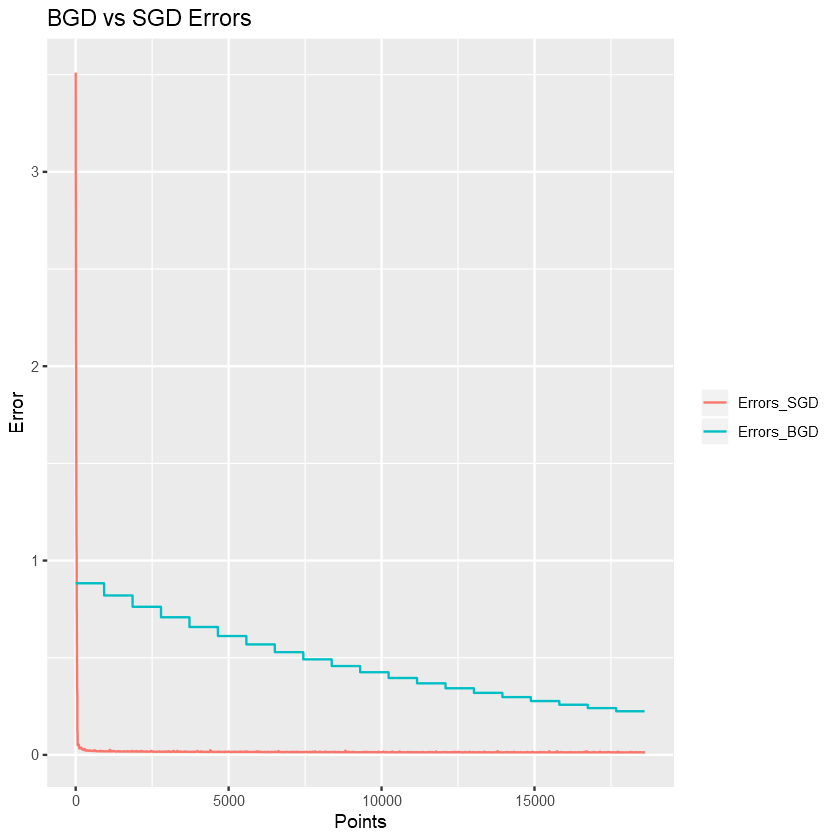

In [47]:
# reshape for visualization
errors.m <- melt(errors, id='Points')
names(errors.m) <- c('Points', 'Type', 'Error')
#head(errors.m)

# plot the BGD and SGD errors
ggplot(data=errors.m, aes(x=Points, y=Error, color=Type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) +
       ggtitle("BGD vs SGD Errors") + theme_grey()

d. Explain (in your Jupyter Notebook file) your observation based on the errors plot you generated in Part c. Particularly, discuss the convergence speed and the fluctuations you see in the error trends.

**Answer**
* The above graph compares the error rate of SGD and BGD algorithm as the number of data points increases.
* Since SGD calculates weight parameters for every point in the dataset whereas BGD calculates weight over the mean of the dataset, there is only one BGD error corresponding to 930 (number of data points in 1 sample) errors of SGD.
* It is observed from the graph that as the number of samples increases, the error rate of both SGD and BGD algorithms decreases.
* However, the convergence rate of SGD algorithm is very high as compared to the BGD, since computations are performed for every input element (X) of the dataset. 
* Also, the fluctuations in the errors of BGD remain constant over the dataset since the error is constant over the dataset. In contrast, very fine fluctuations can be seen the error values of BGD due to the same above reason.
* SGD algorithm seems computationally very expensive, but it results in a better weight parameters compared to the BGD algorithm.